### Use a Random Forests Classifier to determine the Top 5 features for classifying popularity

In [1]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [2]:
# import dataframe from spotify-EDA file

streams_df = pd.read_csv(r'/Users/adityamxr/Desktop/spotify-time-series/data-analysis/streams_df_preprocessing.csv')

In [3]:
# verify import
streams_df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cleaned_broad_genre
0,0.995,0.708,158648,0.1950,0,0.563,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928,unknown
1,0.994,0.379,282133,0.0135,0,0.901,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928,early music
2,0.604,0.749,104300,0.2200,0,0.000,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928,epicore
3,0.995,0.781,180760,0.1300,0,0.887,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928,tango
4,0.990,0.210,687733,0.2040,0,0.908,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928,classical


In [4]:
# before encoding the cleaned_broad_genre feature, create copy of dataframe

encoded_df = streams_df.copy()

# initalize LabelEncoder()
label_enc = LabelEncoder()
encoded_df['labelenc_genre'] = label_enc.fit_transform(encoded_df['cleaned_broad_genre'])

# verify encoded genre
encoded_df['labelenc_genre'].head(5)

0    500
1    138
2    149
3    477
4     96
Name: labelenc_genre, dtype: int64

In [5]:
# save encoded dataframe
encoded_df.to_csv('label_encoded_streams_df.csv', index =False)

In [10]:
# check for missing values in encoded_df
print('Number of missing values in encoded dataframe: \n', encoded_df.isnull().sum())

Number of missing values in encoded dataframe: 
 acousticness           0
danceability           0
duration_ms            0
energy                 0
explicit               0
instrumentalness       0
liveness               0
loudness               0
mode                   0
popularity             0
speechiness            0
tempo                  0
valence                0
year                   0
cleaned_broad_genre    0
labelenc_genre         0
dtype: int64


In [11]:
# summary statistics for the popularity column to ascertain bin size
print(encoded_df['popularity'].describe())

count    169909.000000
mean         31.556610
std          21.582614
min           0.000000
25%          12.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64


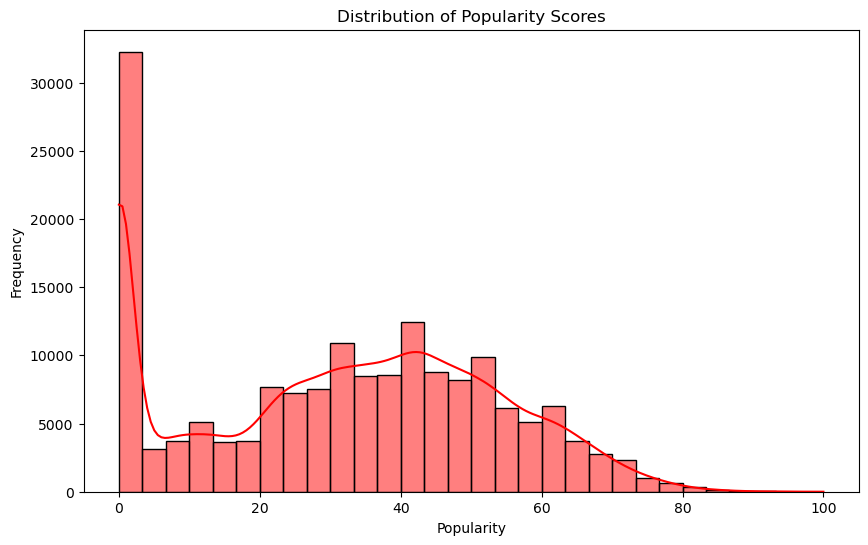

In [14]:
# plot the distribution of popularity to ascertain bin size
plt.figure(figsize=(10, 6))
sns.histplot(encoded_df['popularity'], bins=30, kde=True, color='red')
plt.title('Distribution of Popularity Scores')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

Distribution of binned popularity:
popularity_binned
Very Low     40468
Low          36256
Medium       57327
High         32042
Very High     3816
Name: count, dtype: int64

Number of NaN values in 'popularity_binned': 0


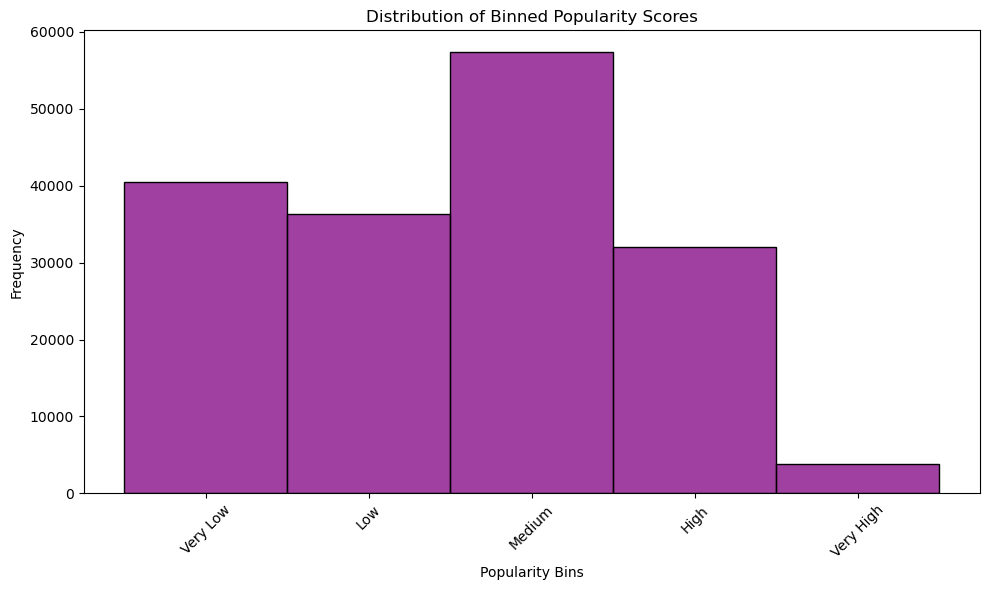

In [15]:
# define bins for popularity scores
new_bins = [-1, 10, 30, 50, 70, 100]
bin_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# apply the bins to the popularity column
encoded_df['popularity_binned'] = pd.cut(encoded_df['popularity'], bins=new_bins, labels=bin_labels)

# check the distribution of the new bins
print("Distribution of binned popularity:")
print(encoded_df['popularity_binned'].value_counts(sort=False))

# check for any NaN values
print("\nNumber of NaN values in 'popularity_binned':", encoded_df['popularity_binned'].isna().sum())

# visualize the binned popularity
plt.figure(figsize=(10, 6))
sns.histplot(encoded_df['popularity_binned'], kde=False, color='purple')

# add title and labels
plt.title('Distribution of Binned Popularity Scores')
plt.xlabel('Popularity Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.tight_layout()  # adjust layout to prevent cutting off labels
plt.show()

### Feature scaling, although unnecessary for rf classification since rf's are invariant to monotonic transformations, can help with feature importance since the goal is to:

- Determine top 5 features using rf classification. Moreover, since the end goal is to forecast a popularity trend for these top features, scaling them would have to be done anyway

### However: 
- duration_ms should be converted to seconds to make the difference between features more discernable
- mode and explicit features are binary so scaling is unnecessary for them
- year feature should be dropped from the encoded_df since it could cause data leakage and could potentially skew the results

In [23]:
# perform additional preprocessing on a copy of the encoded_df, since one of the steps is to drop year feature

final_df = encoded_df.copy()
final_df['duration_s'] = final_df['duration_ms'] / 1000 # convert ms to s to standardize for feature discernability

In [25]:
# drop redudant duration_ms column
final_df = final_df.drop(columns='duration_ms')

In [26]:
# verify conversion
final_df.head()

,acousticness,danceability,energy,explicit,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cleaned_broad_genre,labelenc_genre,popularity_binned,duration_s
0,0.995,0.708,0.1950,0,0.563,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928,unknown,500,Very Low,158.648
1,0.994,0.379,0.0135,0,0.901,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928,early music,138,Very Low,282.133
2,0.604,0.749,0.2200,0,0.000,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928,epicore,149,Very Low,104.300
3,0.995,0.781,0.1300,0,0.887,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928,tango,477,Very Low,180.760
4,0.990,0.210,0.2040,0,0.908,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928,classical,96,Very Low,687.733


In [27]:
# drop unnecessary columns
columns_to_drop = ['popularity', 'cleaned_broad_genre', 'year']
final_df = final_df.drop(columns= columns_to_drop)

In [28]:
# verify drop
final_df.head()

,acousticness,danceability,energy,explicit,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,labelenc_genre,popularity_binned,duration_s
0,0.995,0.708,0.1950,0,0.563,0.1510,-12.428,1,0.0506,118.469,0.7790,500,Very Low,158.648
1,0.994,0.379,0.0135,0,0.901,0.0763,-28.454,1,0.0462,83.972,0.0767,138,Very Low,282.133
2,0.604,0.749,0.2200,0,0.000,0.1190,-19.924,0,0.9290,107.177,0.8800,149,Very Low,104.300
3,0.995,0.781,0.1300,0,0.887,0.1110,-14.734,0,0.0926,108.003,0.7200,477,Very Low,180.760
4,0.990,0.210,0.2040,0,0.908,0.0980,-16.829,1,0.0424,62.149,0.0693,96,Very Low,687.733


In [30]:
# feature scaling

features_scale = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','duration_s']

# intialize standardscaler
scaler = StandardScaler()

# fit and transform features to scale
final_df[features_scale] = scaler.fit_transform(final_df[features_scale])

# verify scaled features
print(final_df[features_scale].head())

   acousticness  danceability    energy  instrumentalness  liveness  loudness  \
0      1.332319      0.968662 -1.097999          1.296562 -0.314998 -0.186652   
1      1.329664     -0.907636 -1.776785          2.389253 -0.737519 -3.014729   
2      0.294154      1.202486 -1.004503         -0.523513 -0.495997 -1.509457   
3      1.332319      1.384983 -1.341091          2.343994 -0.541247 -0.593587   
4      1.319044     -1.871449 -1.064341          2.411883 -0.614778 -0.963288   

   speechiness     tempo   valence  duration_s  
0    -0.289840  0.049500  0.940924   -0.599713  
1    -0.319186 -1.073199 -1.735454    0.418119  
2     5.568626 -0.317996  1.325822   -1.047680  
3    -0.009722 -0.291114  0.716082   -0.417454  
4    -0.344530 -1.783425 -1.763655    3.761300  
